In [1]:
import sys
import os
import pickle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from scipy.linalg import inv
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable

from data.dataLoader import dataLoader
from fit.ConditionalLeastSquaresLogLin import ConditionalLeastSquaresLogLin
from inference.ParametricFit import ParametricFit
from simulation.Simulate import Simulate

from nphc.main import NPHC
from nphc.main import starting_point

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

model_name = 'simulation-hawkes'
n_sims = 1
inputs_path = os.path.join(os.getcwd(), 'data', 'inputs')
outputs_path = os.path.join(os.getcwd(), 'data', 'outputs')

2024-05-22 14:54:23.500129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


# Generate Fake Data

## Create Fake Params

In [2]:
mat = np.zeros((12,12))
for i in range(12):
    mat[i][i] = .66
for i in range(12):
    for j in range(12):
        if i == j: continue
        mat[i][j] = np.random.choice([1,-1])*mat[i][i]*np.exp(-.75*np.abs(j-i))

In [3]:
cols = ["lo_deep_Ask", "co_deep_Ask", "lo_top_Ask","co_top_Ask", "mo_Ask", "lo_inspread_Ask" ,
            "lo_inspread_Bid" , "mo_Bid", "co_top_Bid", "lo_top_Bid", "co_deep_Bid","lo_deep_Bid" ]

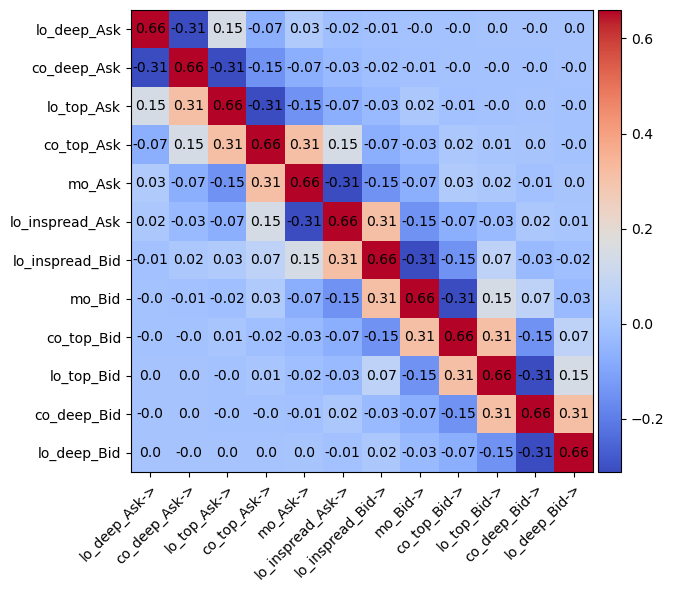

In [4]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
# fig.savefig("heatmap.png")
plt.show()


In [5]:
# norm should be less than 1
np.max(np.linalg.eig(mat)[0])

(1.0655378228076058+0j)

In [6]:
# create fake TOD params - 1.0 for now but can be changed to whatever you wish
faketod = {}
for k in cols:
    faketod[k] = {}
    for k1 in np.arange(13):
        faketod[k][k1] = 1.0

# check if dir exists
if not os.path.exists(os.path.join(inputs_path, model_name)):
    os.makedirs(os.path.join(inputs_path, model_name))

# save the fake data
with open(os.path.join(inputs_path, model_name, "fakeData_Params_sod_eod_dictTOD_constt"), "wb") as f:
    pickle.dump(faketod, f)

In [7]:
# Create fake power law kernel params from the above norm matrix
paramsFake = {}
for i in range(12):
    paramsFake[cols[i]] = 0.1*np.random.choice([0.3,0.4,0.5,0.6,0.7])
    for j in range(12):
        maxTOD = np.max(list(faketod[cols[j]].values()))
        beta = np.random.choice([1.5,1.6,1.7,1.8,1.9])
        gamma = (1+np.random.rand())*5e3
        alpha = np.abs(mat[i][j])*gamma*(beta-1)/maxTOD
        paramsFake[cols[i]+"->"+cols[j]] = (np.sign(mat[i][j]), np.array([alpha, beta, gamma]))

In [8]:
mat = np.zeros((12,12))
for i in range(len(cols)):
    for j in range(len(cols)):
        kernelParams = paramsFake.get(cols[j]+"->"+cols[i], None)
        if kernelParams is None: continue
        mat[i][j] = kernelParams[0]*kernelParams[1][0]/((-1 + kernelParams[1][1])*kernelParams[1][2])

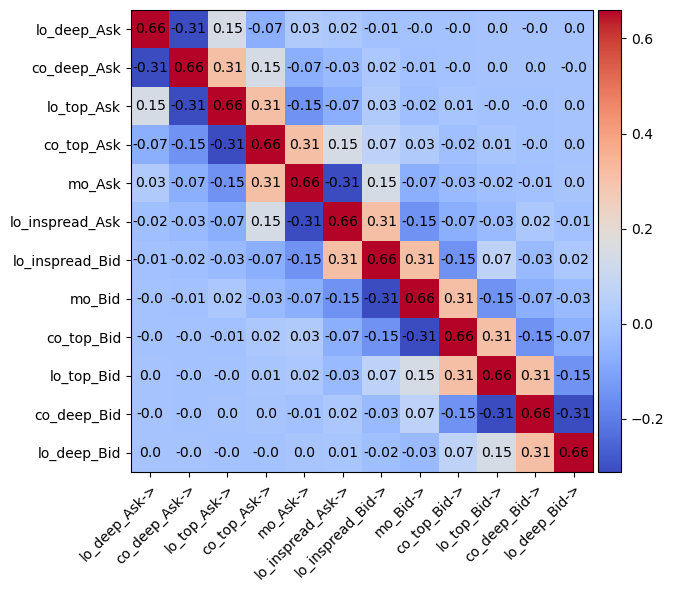

In [9]:
# norm matrix from this fake power law kernels - does it match the above figure? - YES.
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
# fig.savefig("heatmap.png")
plt.show()


In [10]:
with open(os.path.join(inputs_path, model_name, "fake_ParamsInferredWCutoff_sod_eod_true"), "wb") as f:
    pickle.dump(paramsFake, f)

## Simulate Fake LOB Data

In [11]:
paramsPath = os.path.join(inputs_path, model_name, "fake_ParamsInferredWCutoff_sod_eod_true")
todPath = os.path.join(inputs_path, model_name, "fakeData_Params_sod_eod_dictTOD_constt")
simulate = Simulate()

# check if dir exists
if not os.path.exists(os.path.join(outputs_path, model_name)):
    os.makedirs(os.path.join(outputs_path, model_name))

#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
for i in range(n_sims):
    T, lob, lobL3 = simulate.run(T=1000, # 6.5*3600
                                 paramsPath=paramsPath, 
                                 todPath=todPath, 
                                 beta=1., 
                                 avgSpread=.01, 
                                 spread0=5, 
                                 price0=45,
                                 verbose=True)
    
    fakeSimPath = os.path.join(outputs_path, model_name, f"fake_simulated_sod_eod_{i}")

    with open(fakeSimPath, "wb") as f:
        pickle.dump((T, lob, lobL3), f)

spectral radius =  (1.0655378228076062+0j)
[0.06999999999999999, 0.03, 0.05, 0.03, 0.04000000000000001, 0.3000000000000256, 0.20000000000001708, 0.03, 0.03, 0.04000000000000001, 0.06, 0.03]
0.8454885229941844
[0.06503757869185729, 0.027873248010795985, 0.04645541335132665, 0.027873248010795985, 0.03716433068106133, 1.3936624005400369, 0.9291082670266915, 0.027873248010795985, 0.027873248010795985, 0.03716433068106133, 0.05574649602159197, 0.027873248010795985]
2.703705057047607
0.5470429509453909
10342.208504096921
        event      time  size
0  co_top_Ask  0.547043     0
{'Ask_touch': (45.02, 80.0), 'Bid_touch': (44.97, 703), 'Ask_deep': (45.03, 1923), 'Bid_deep': (44.96, 260)}
spectral radius =  (1.0655378228076062+0j)
10342.208504096921
[0.0, 0.0, 0.0, 1138.8209714559416, 352.23616331093973, 1145.0371718278866, 459.8838855332076, 54.85674429595969, 0.0, 12.021922686114763, 0.0, 2.846231178536373]
3165.7030902885867
3165.7030902885867
[0.0, 0.0, 0.0, 432.881935407674, 180.648931522

In [12]:
# save as 12D 
paths = [i for i in os.listdir(os.path.join(os.path.join(outputs_path, model_name))) if ("fake_simulated" in i)]
for p in paths:
    resPath = os.path.join(outputs_path, model_name, p)
    with open(resPath, 'rb') as f:
        results = pickle.load(f)
    
    ask_t = []
    bid_t = []
    ask_d = []
    bid_d= []
    event = []
    time = []
    for r, j in zip(results[1][1:], results[0][1:]):
        ask_t.append(r['Ask_touch'][0])
        bid_t.append(r['Bid_touch'][0])
        ask_d.append(r['Ask_deep'][0])
        bid_d.append(r['Bid_deep'][0])
        event.append(j[0])
        time.append(j[1])
    df = pd.DataFrame({"Time" : time, "event" : event, "Ask Price 1" : ask_t, "Bid Price 1": bid_t, "Ask Price 2": ask_d, "Bid Price 2" : bid_d})
    df['BidDiff'] = df['Bid Price 1'].diff()
    df['AskDiff'] = df['Ask Price 1'].diff()
    df['BidDiff2']= df['Bid Price 2'].diff()
    df['AskDiff2']= df['Ask Price 2'].diff()
    id = (resPath.split("/")[-1]).split("_")[-1]
    df["Date"] = id
    df.to_csv(os.path.join(outputs_path, model_name, f"fake_{id}_12D.csv"))

## Bin to custom bins

In [13]:
#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
ric = "fake"
d = 0

l = dataLoader(ric, d, d, dataPath = os.path.join(outputs_path, model_name))
for d in range(n_sims):
    df = pd.read_csv(os.path.join(l.dataPath, f"fake_{d}_12D.csv"))
    data = {str(i) : list(df.groupby('event')['Time'].apply(np.array)[cols].values)}
    cls = ConditionalLeastSquaresLogLin(data, loader = l) 
    cls.runTransformDate()

0
lo_deep_Ask
co_deep_Ask
lo_top_Ask
co_top_Ask
mo_Ask
lo_inspread_Ask
lo_inspread_Bid
mo_Bid
co_top_Bid
lo_top_Bid
co_deep_Bid
lo_deep_Bid
done with binning


# Fit Fake Data

## Hawkes Graph

In [14]:
big_data = []
cols = ["lo_deep_Ask", "co_deep_Ask", "lo_top_Ask","co_top_Ask", "mo_Ask", "lo_inspread_Ask" ,
            "lo_inspread_Bid" , "mo_Bid", "co_top_Bid", "lo_top_Bid", "co_deep_Bid","lo_deep_Bid" ]
for d in range(n_sims): #pd.date_range(dt.date(2019,1,2), dt.date(2019,1,4)):
    
    df = pd.read_csv(os.path.join(outputs_path, model_name, f"fake_{d}_12D.csv"))
    
    timestamps = list(df.groupby('event')['Time'].apply(np.array)[cols].values)
    big_data.append(timestamps)

In [15]:
nphc = NPHC()
nphc.fit(big_data,half_width=1.,filtr="rectangular",method="parallel_by_day")
cumulants_list = [nphc.L, nphc.C, nphc.K_c]

start_point = starting_point(cumulants_list, random=True)
R_pred = nphc.solve(training_epochs=50000,display_step=500,learning_rate=1e-2,optimizer='adam')
d = len(nphc.L[0])

G_pred = np.eye(d) - inv(R_pred)

L is computed
C is computed
K_c is computed
Epoch: 0000 log10(cost)= 0.113308937


2024-05-22 14:56:22.045786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 14:56:22.048398: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch: 0500 log10(cost)= -1.744720021
Epoch: 1000 log10(cost)= -1.886708513
Epoch: 1500 log10(cost)= -1.948690494
Epoch: 2000 log10(cost)= -1.997284739
Epoch: 2500 log10(cost)= -2.036472471
Epoch: 3000 log10(cost)= -2.075100581
Epoch: 3500 log10(cost)= -2.116519311
Epoch: 4000 log10(cost)= -2.166943067
Epoch: 4500 log10(cost)= -2.218583478
Epoch: 5000 log10(cost)= -2.248887961
Epoch: 5500 log10(cost)= -2.260560772
Epoch: 6000 log10(cost)= -2.265165486
Epoch: 6500 log10(cost)= -2.267683369
Epoch: 7000 log10(cost)= -2.269631519
Epoch: 7500 log10(cost)= -2.271364830
Epoch: 8000 log10(cost)= -2.273001520
Epoch: 8500 log10(cost)= -2.274594673
Epoch: 9000 log10(cost)= -2.277122364
Epoch: 9500 log10(cost)= -2.279416183
Epoch: 10000 log10(cost)= -2.280739894
Epoch: 10500 log10(cost)= -2.281780028
Epoch: 11000 log10(cost)= -2.278383781
Epoch: 11500 log10(cost)= -2.284664169
Epoch: 12000 log10(cost)= -2.285238574
Epoch: 12500 log10(cost)= -2.285280219
Epoch: 13000 log10(cost)= -2.285300586
Epoch

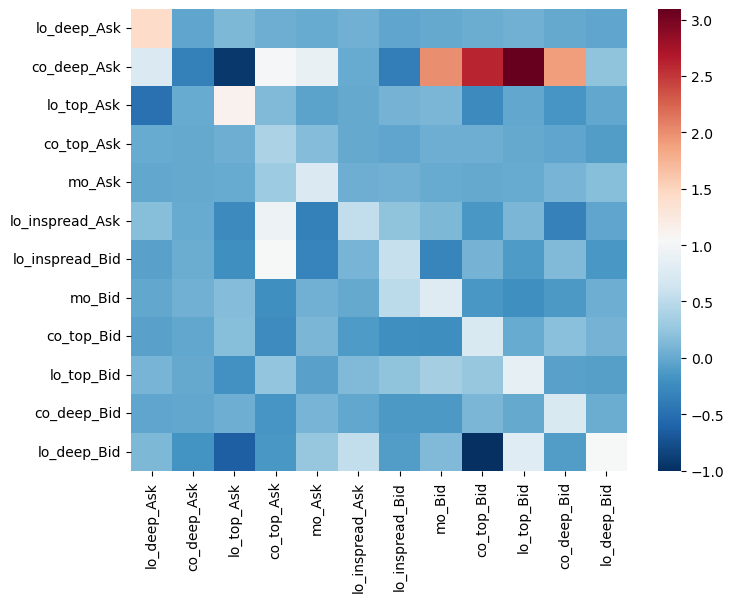

In [16]:
dimensions = cols 
sns_plot = sns.heatmap(G_pred.T,cmap="RdBu_r",xticklabels=dimensions,yticklabels=dimensions)

In [17]:
boundsDict = {}
for i in range(G_pred.shape[0]):
    for j in range(G_pred.shape[1]):
        boundsDict[cols[i]+"->"+cols[j]] = np.sign(G_pred[i][j])

with open(os.path.join(outputs_path, model_name, "fake_2019-01-02_2019-03-31_graphDict"), "wb") as f:
    pickle.dump(boundsDict, f)

## 12D Hawkes Non-Parametric Fit:

In [18]:
ric = "fake"
dictIp = {}
d = 0
l = dataLoader(ric, d, d, dataPath = os.path.join(outputs_path, model_name))
for d in range(n_sims):
    dictIp[d] = []

path_dictTOD = os.path.join(inputs_path, model_name, "fakeData_Params_sod_eod_dictTOD_constt")
cls = ConditionalLeastSquaresLogLin(dictIp, loader = l, solver="osqp", path_dictTOD = path_dictTOD)
thetas = cls.fitConditionalInSpread(spreadBeta = 1., avgSpread = 1.)
with open(os.path.join(l.dataPath, f"{ric}_Params_2019-01-02_2019-03-31_CLSLogLin_19" , "wb")) as f:
    pickle.dump(thetas, f)

lo_deep_Ask
(186,)
(186,)
      bin  lo_deep_Ask  spread
0       1            1   0.010
1    1593            1   0.010
2  353524            1   0.020
3  353525            2   0.015
4  406730            1   0.020
co_deep_Ask
(315,)
(315,)
     bin  co_deep_Ask  spread
0      1            1    0.01
1  92094            1    0.01
2  92153            1    0.01
3  93441            1    0.01
4  93444            2    0.01
lo_top_Ask
(346,)
(346,)
   bin  lo_top_Ask  spread
0    1           1    0.02
1    4           1    0.02
2    5           3    0.02
3    6           2    0.02
4    7           1    0.01
co_top_Ask
(382,)
(382,)
      bin  co_top_Ask  spread
0       1           1    0.02
1  511360           1    0.06
2  511364           1    0.06
3  550428           1    0.01
4  588816           1    0.01
mo_Ask
(39,)
(39,)
       bin  mo_Ask  spread
0        1       1    0.01
1   342103       1    0.01
2   754516       1    0.01
3  1316768       1    0.01
4  2537980       1    0.01
lo_inspre

ValueError: operands could not be broadcast together with shapes (8558,217) (2724,1) 

## Infer power law params:

In [ ]:
inference = ParametricFit()
a, b = inference.run(dt.date(2019,1,2), dt.date(2019,3,31), ric = "fake" , avgSpread = 0.01, spreadBeta=1. , suffix = "_CLSLogLin_19")

# Simulate LOB from Fitted Fake Params

In [ ]:
#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
for i in range(10):
    T, lob, lobL3=simulate.simulate(6.5*3600, "fake_ParamsInferredWCutoff_2019-01-02_2019-01-31_CLSLogLin_19", "fakeData_Params_sod_eod_dictTOD_constt", beta = 1., avgSpread = 0.01, spread0 = 5, price0 = 45)
    with open("./simulated_data/fake_simulated_CLSLogLinFit_sod_eod_"+ str(i) , "wb") as f:
        pickle.dump((T, lob, lobL3), f)